In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import Series, DataFrame
import pytz
from pytz import common_timezones, all_timezones
import matplotlib
matplotlib.style.use('ggplot')
%matplotlib inline
from datetime import datetime


The much more difficult analytic problems involve medium data and—especially troublesome—really small data. Using an argument similar to Gelman’s, if big-data problems are big enough to be readily solved, then we should be more interested in the not-quite-big-enough datasets.

$
P(A|X) = \frac{P(X|A) P(A)}{P(X)}
$

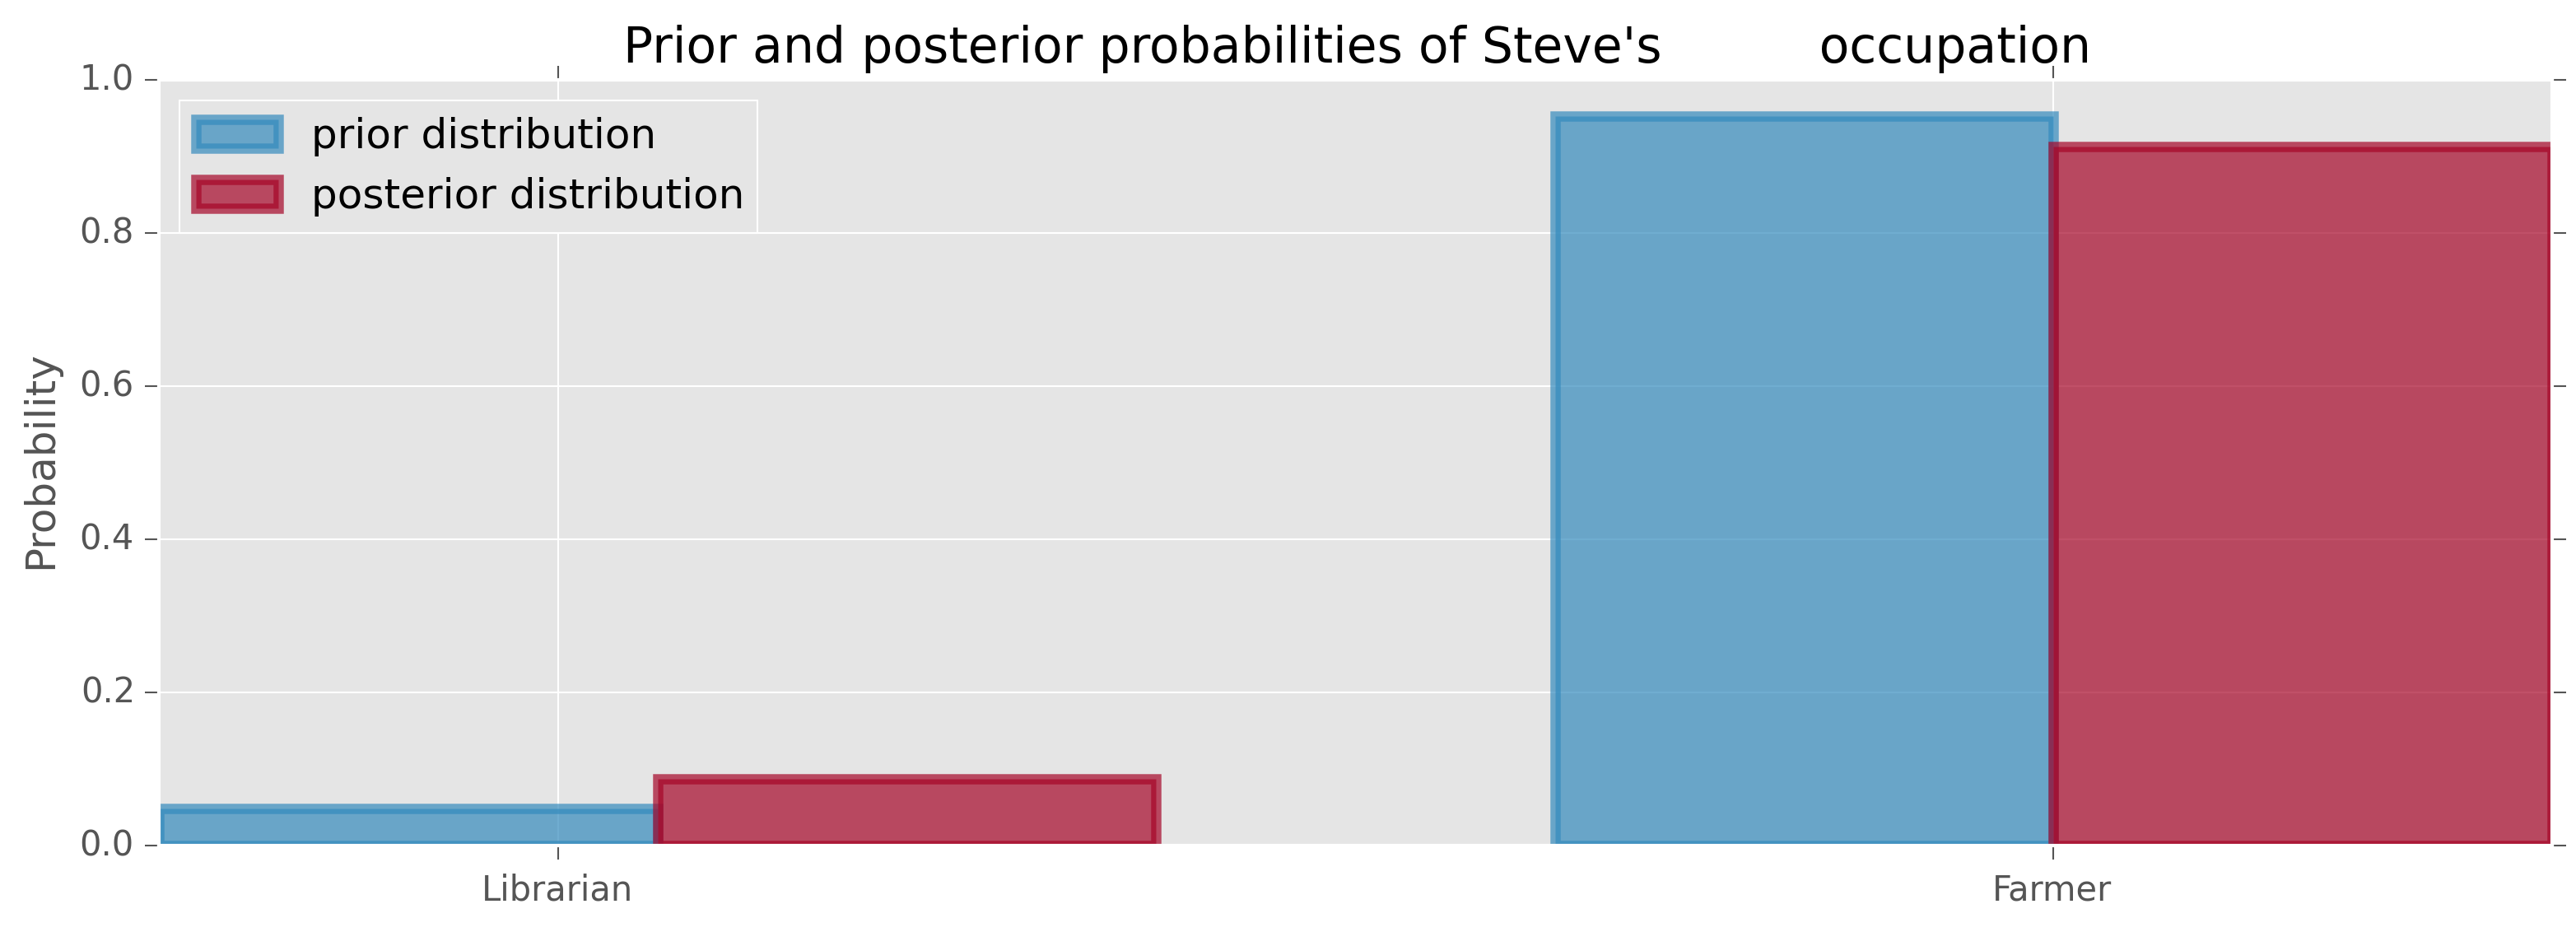

In [2]:
from IPython.core.pylabtools import figsize
import numpy as np 
from matplotlib import pyplot as plt
figsize(12.5, 4)
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['figure.dpi'] = 300

colors = ["#348ABD", "#A60628"]
prior = [1/21., 20/21.]
posterior = [0.087,1-0.087]
plt.bar([0, .7], prior, alpha=0.70, width=0.25,
        color=colors[0], label="prior distribution",
        lw="3", edgecolor="#348ABD")

plt.bar([0+0.25, .7+0.25], posterior, alpha=0.7,
        width=0.25, color=colors[1],
        label="posterior distribution",
        lw="3", edgecolor="#A60628")

plt.xticks([0.20, 0.95], ["Librarian", "Farmer"])
plt.title("Prior and posterior probabilities of Steve's\
          occupation")
plt.ylabel("Probability")
plt.legend(loc="upper left");

### 1.3.1 Discrete case


Probablity mass functions.

We say that Z is Poisson-distributed if:

$
P(Z = k) = \frac{\lambda^{k} e^{-\lambda}}{k !}, k = 0, 1, 2, \cdots
$

For the Poisson distribution, $\lambda$ can be any positive number. By increasing $\lambda$, we add more probability to larger values; conversely, by decreasing$\lambda$, we add more probability to smaller values. One can describe $\lambda$ as the intensity of the Poisson distribution.

If a random variable Z has a Poisson mass distribution, we note this by writing

$
Z \sim \mbox{Poi}(\lambda)
$

One useful property of the Poisson distribution is that its expected value is equal to its parameters. That is,
$
E[Z|\lambda] = \lambda
$

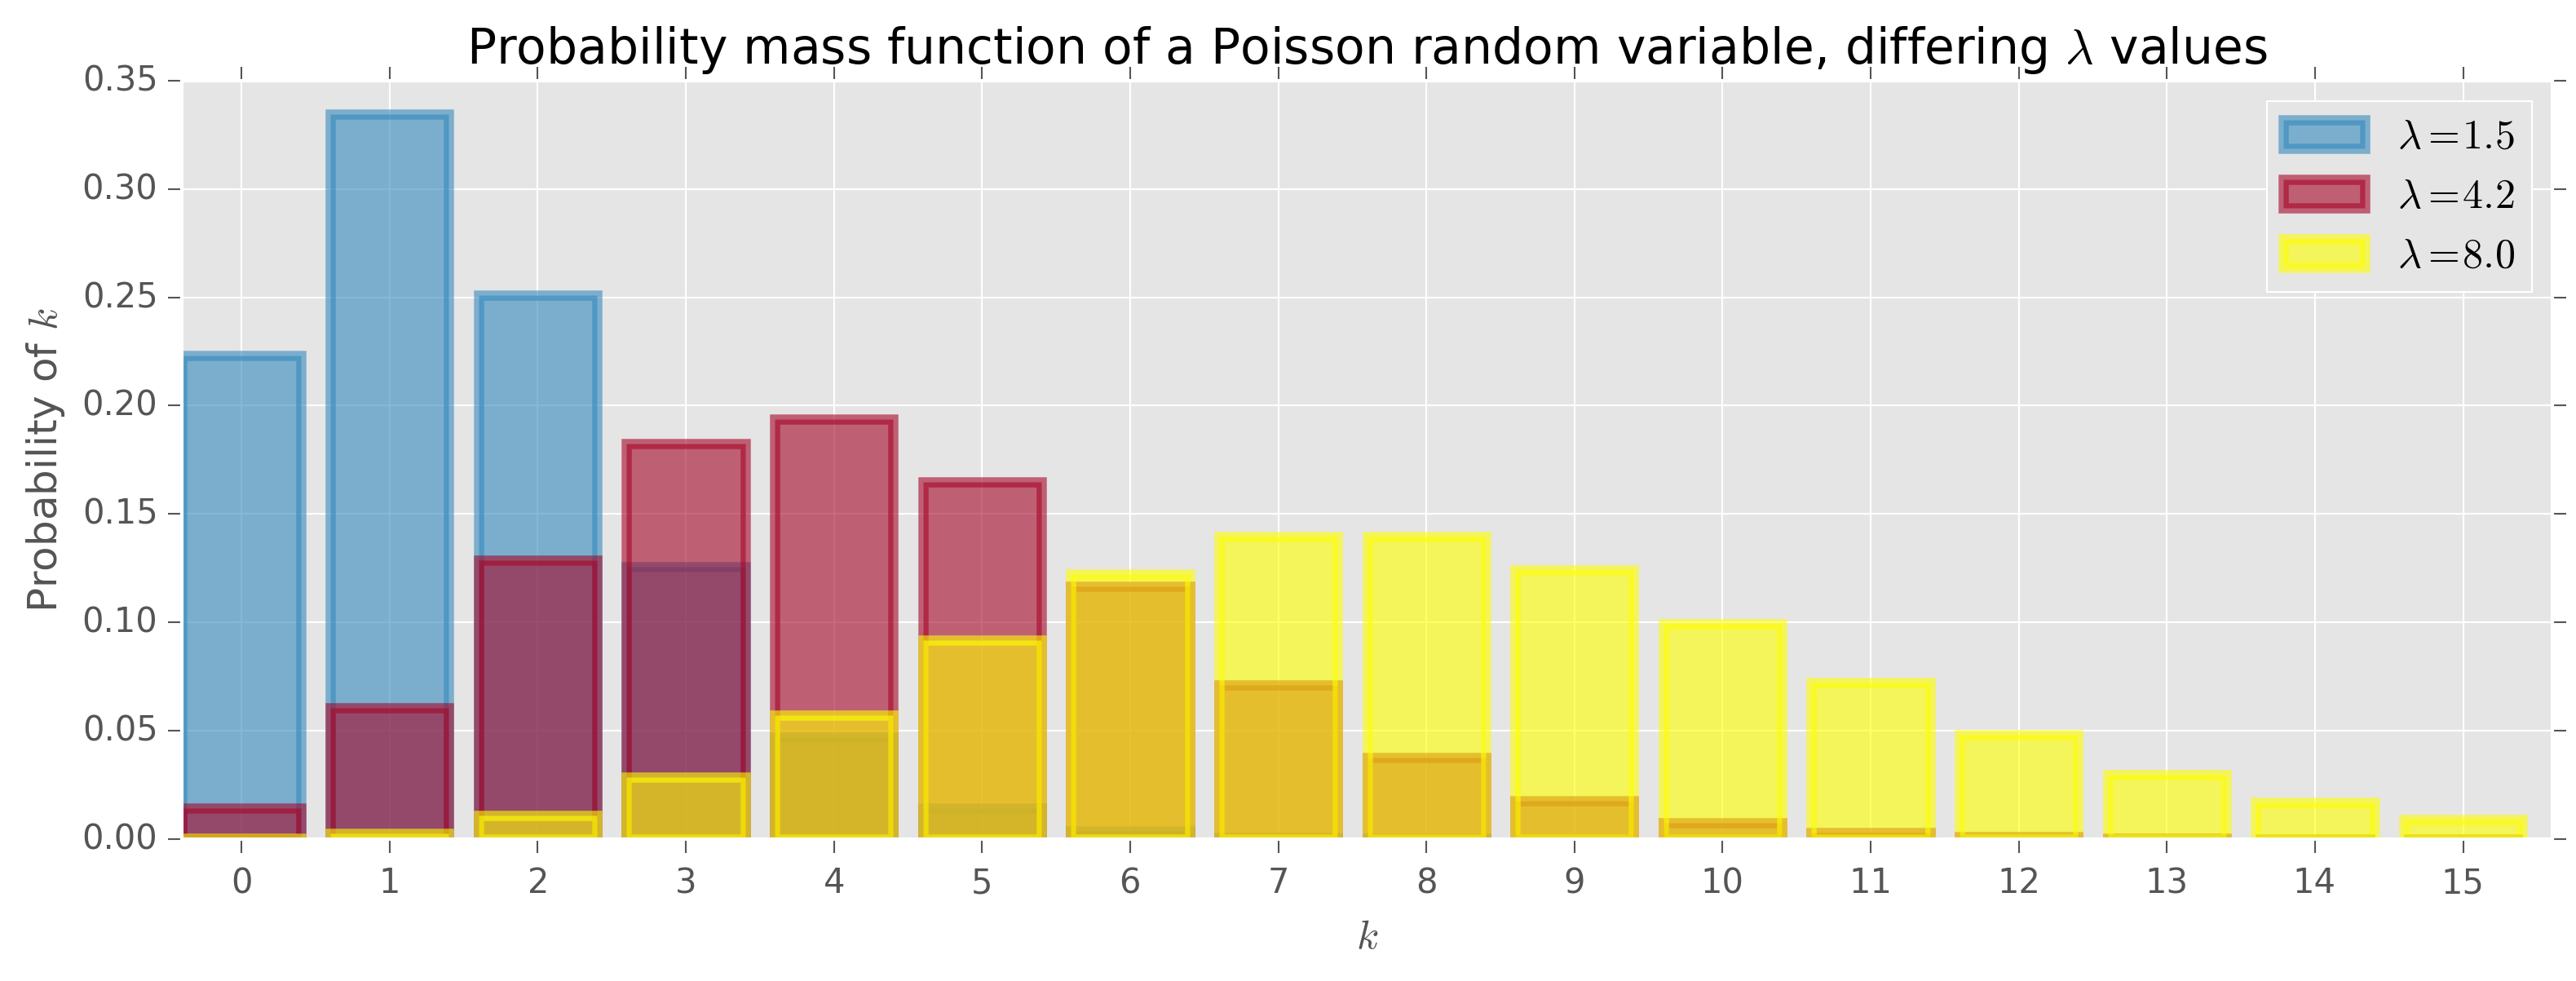

In [5]:
figsize(12.5, 4)

import scipy.stats as stats
a = np.arange(16)
poi = stats.poisson
lambda_ = [1.5, 4.25, 8]
colors = ["#348ABD", "#A60628", "#ffff00"]

plt.bar(a, poi.pmf(a, lambda_[0]), color=colors[0],
       label="$\lambda = %.1f $" % lambda_[0], alpha=0.60,
       edgecolor=colors[0], lw="3")

plt.bar(a, poi.pmf(a, lambda_[1]), color=colors[1],
       label="$\lambda = %.1f $" % lambda_[1], alpha=0.60,
       edgecolor=colors[1], lw="3")


plt.bar(a, poi.pmf(a, lambda_[2]), color=colors[2],
       label="$\lambda = %.1f $" % lambda_[2], alpha=0.60,
       edgecolor=colors[2], lw="3")

plt.xticks(a + 0.4, a)
plt.legend()
plt.ylabel("Probability of $k$")
plt.xlabel("$k$")
plt.title("Probability mass function of a Poisson random variable, differing $\lambda$ values")

## 1.3.2 Continuous Case

An example of a continouus random variable is a random variable with _exponential density_.

$
f_{Z}(z|\lambda) = \lambda e^{-\lambda z}, z \geq 0
$

When a random vairable Z has an exponential distibution with parameter $\lambda$, we saw Z is _exponential_ and write

$
Z \sim \mbox{Exp}(\lambda)
$

Given a specific $\lambda$, the expected value of an exponential random variable is equal to the inverse of $\lambda$.That is,

$
E[Z|\lambda] = \frac{1}{\lambda}
$

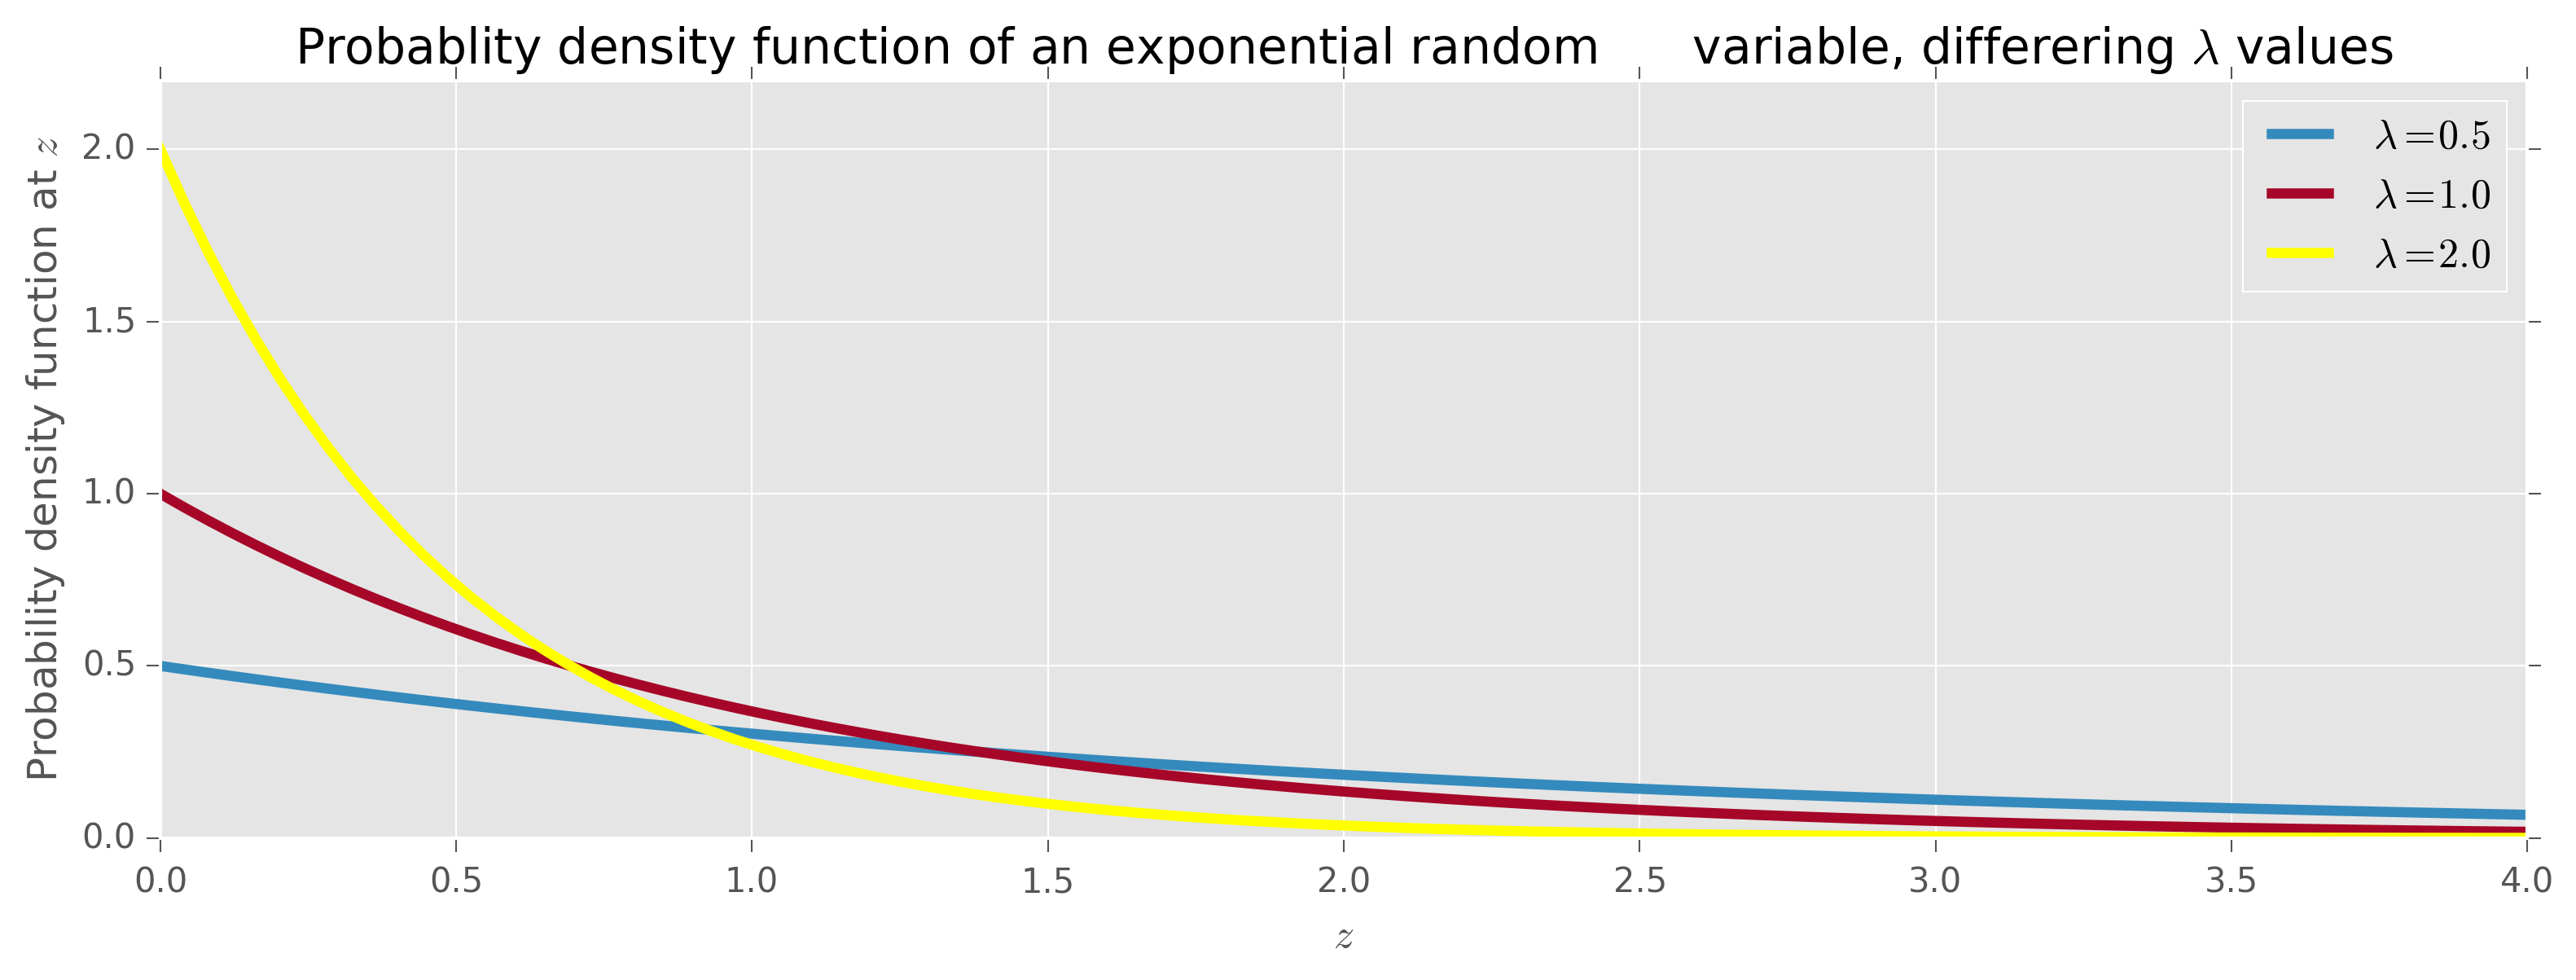

In [8]:
a = np.linspace(0, 4, 100)
expo = stats.expon
lambda_ = [0.5, 1,2]

for l, c in zip(lambda_, colors):
    plt.plot(a, expo.pdf(a, scale=1./l), lw=3,
            color=c,label="$\lambda = %.1f $" % l)
   # plt.fill_between(a, expo.pdf(a, scale=1./1), color=c, alpha=.33)
    
plt.legend()
plt.ylabel("Probability density function at $z$")
plt.xlabel("$z$")
plt.ylim(0, 2.2)
plt.title("Probablity density function of an exponential random\
      variable, differering $\lambda$ values")


#### 1.3.3 But What is $\lambda$?

This question is what motivates statistics. In the real world, $\lambda$ is hidden from us. We see only Z, and must work backward to try to determine $\lambda$. The problem is difficult because there is no one-to-one mapping from Z to $\lambda$. Many different methods have been created to solve the problem of estimating $\lambda$, but since $\lambda$ is never actually observed, no one can say for certain which method is best!


Bayesian inference is concerned with beliefs about what $\lambda$ might be. Rather than trying to guess $\lambda$ exactly, we can only talk about what $\lambda$ is likely to be by assigning a probability distribution to $\lambda$.



### 1.4 Using Computers to Perform Bayesian Inference for Us

Let's try to model a more interesting example, one that concerns the rate at which a user sends and receives text messages.

(0, 74)

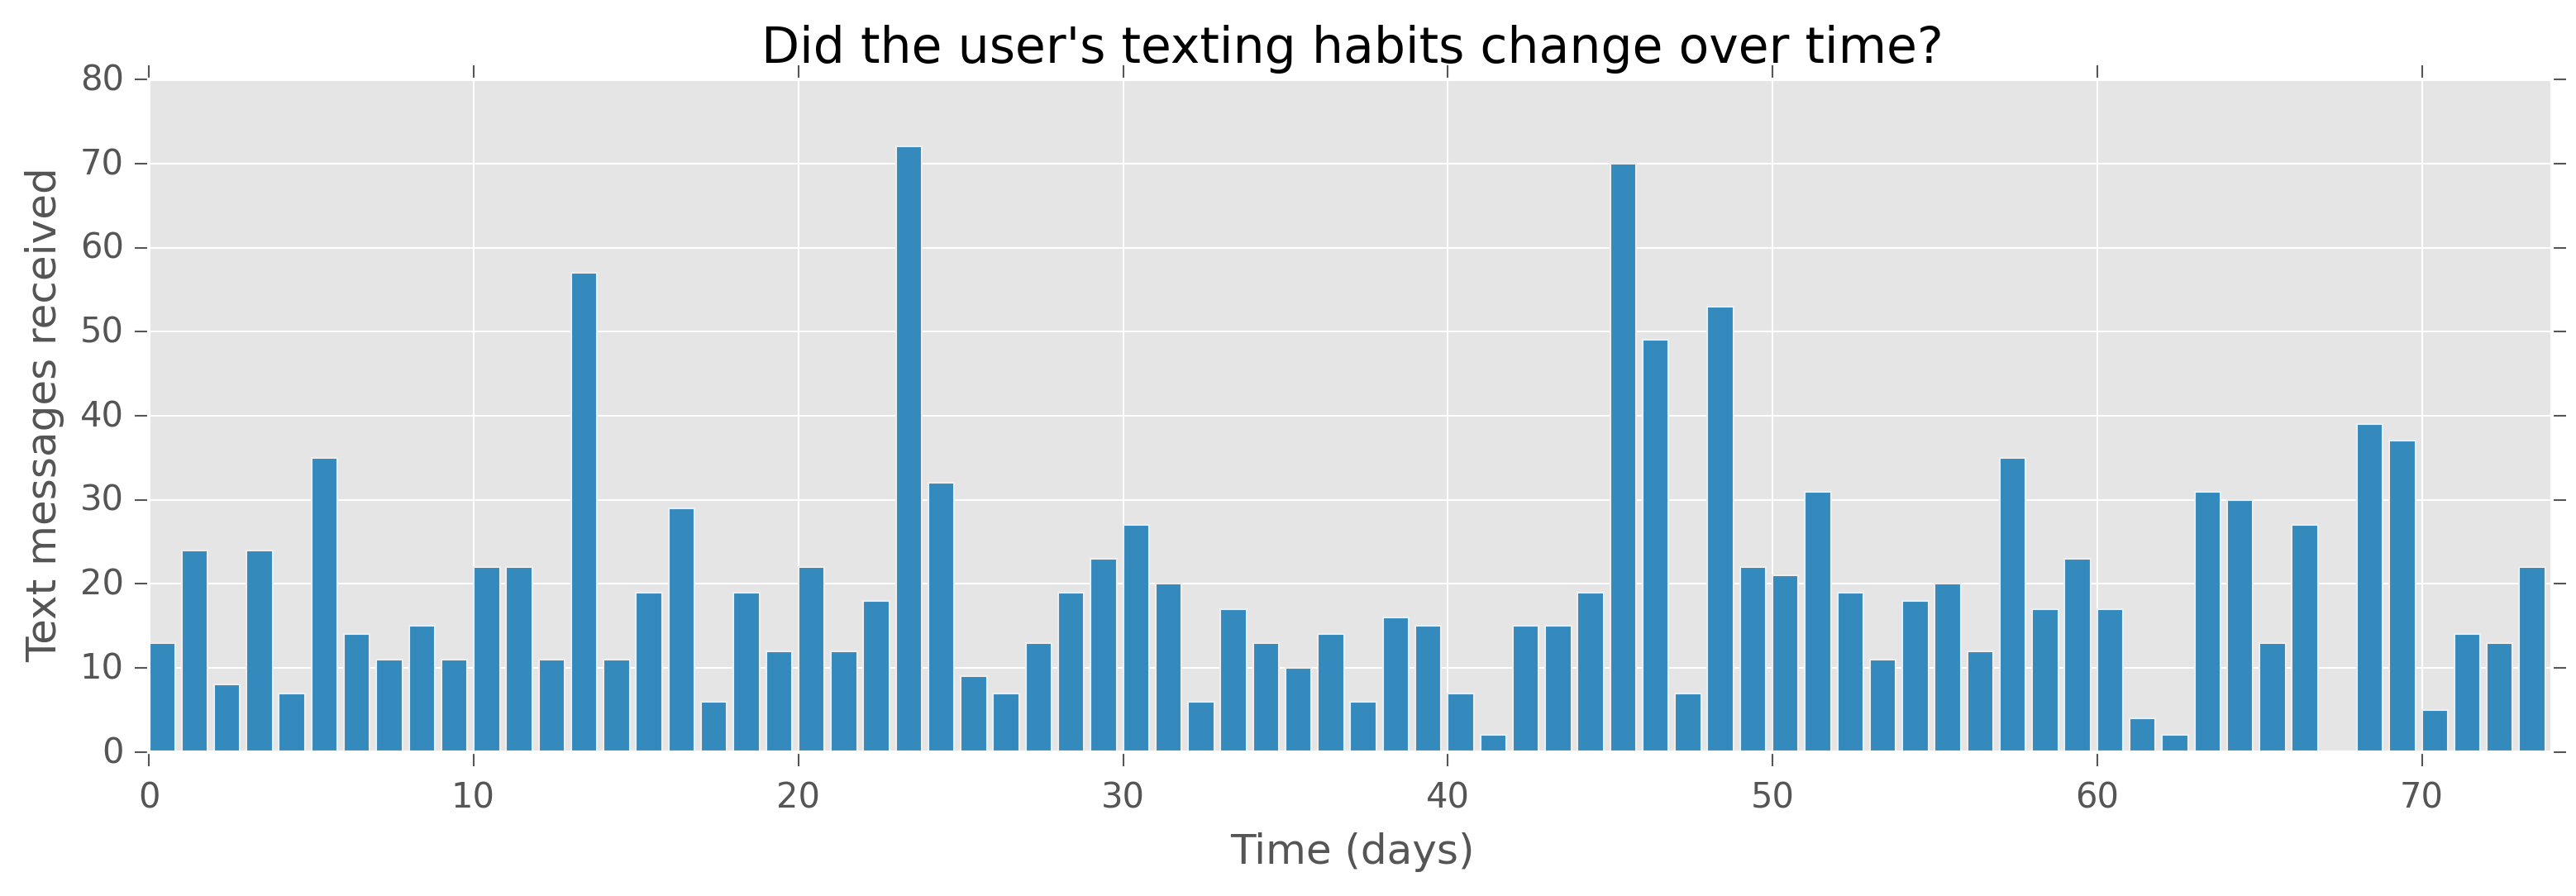

In [12]:
figsize(12.5, 3.5)
count_data = np.loadtxt("data/txtdata.csv")
n_count_data = len(count_data)
plt.bar(np.arange(n_count_data), count_data, color="#348ABD")
plt.xlabel("Time (days)")
plt.ylabel("Text messages received")
plt.title("Did the user's texting habits change over time?")
plt.xlim(0, n_count_data)

How can we start to model this? Well, as we have conveniently already seen, a Poisson random variable is a very appropriate model for this type of count data. Denoting day i’s text-message count by $C_i$,

$ 
C_i \sim \mbox{Poi}(\lambda)
$

We are not sure what the value of the $\lambda$ parameter really is, however. Looking at Figure 1.4.1, it appears that the rate might become higher late in the observation period, which is equivalent to saying that $\lambda$ increases at some point during the observations. (Recall that a higher value of $\lambda$ assigns more probability to larger outcomes. That is, there is a higher probability of many text messages having been sent on a given day.)


How can we represent this observation mathematically? Let’s assume that on some day during the observation period (call it $\tau$), the parameter $\lambda$ suddenly jumps to a higher value. So we really have two $\lambda$ parameters: one for the period before $\tau$, and one for the rest of the observation period. In the literature, a sudden transition like this would be called a switchpoint:


We are interested in inferring the unknown $\lambda$s. To use Bayesian inference, we need to assign prior probabilities to the different possible values of $\lambda$. What would be good prior probability distributions for $\lambda_1$ and $\lambda_2$? Recall that $\lambda$ can be any positive number. As we saw earlier, the exponential distribution provides a continuous density function for positive numbers, so it might be a good choice for modeling $\lambda_i$. But recall that the exponential distribution takes a parameter of its own, so we’ll need to include that parameter in our model. Let’s call that parameter $\alpha$.


$
\lambda_1 \sim \mbox{Exp}(\alpha)
$

$
\lambda_2 \sim \mbox{Exp}(\alpha)
$

$\alpha$ is called a _hyperparameter_ or _parent vairable_.


$
\frac{!}{N} \sum_{i=0}^{N} C_{i} \approx E[\lambda|\alpha] = \frac{1}{\alpha}
$

$
\tau \sim \mbox{DiscreteUniform}(1,70)
$

So after all this, what does our overall prior distribution for the unknown variables look like? Frankly, it doesn’t matter. What we should understand is that it’s an ugly, complicated mess involving symbols only a mathematician could love. And things will only get uglier the more complicated our models become. Regardless, all we really care about is the posterior distribution.

### 1.4.2 Introducing our First Hammer: PyMC

PyMC is a Python library for programming Bayesian analysis.[5] It is a fast, well-maintained library. The only unfortunate part is that its documentation is lacking in certain areas, especially those that bridge the gap between beginner and hacker. One of this book’s main goals is to solve that problem, and also to demonstrate why PyMC is so cool.

We will model this problem using PyMC. This type of programming is called probabilistic programming, an unfortunate misnomer that invokes ideas of randomly generated code and has likely confused and frightened users away from this field. The code is not random; it is probabilistic in the sense that we create probability models using programming variables as the model’s components. Model components are first-class primitives within the PyMC framework.

PyMC code is easy to read. The only novel thing should be the syntax, and I will interrupt the code to explain individual sections. Simply remember that we are representing the model’s components ($\tau$, $\lambda_1$, $\lambda_2$) as variables:

In [19]:
import pymc as pm

alpha = 1.0/count_data.mean()  # recall that count_data is the
                              # variable that holds our text counts
lambda_1 = pm.Exponential("lambda_1", alpha)
lambda_2 = pm.Exponential("lambda_2", alpha)

tau = pm.DiscreteUniform("tau", lower=0, upper=n_count_data)

@pm.deterministic
def lambda_(tau=tau, lambda_1=lambda_1, lambda_2=lambda_2):
    out = np.zeros(n_count_data) # number of data points
    out[:tau] = lambda_1  # lambda before tau is lambda 1
    out[tau:] = lambda_2 # lambda after (and including) tau is lambda 2
    return out


observation = pm.Poisson("obs", lambda_, value=count_data,
                        observed=True)

model = pm.Model([observation, lambda_1, lambda_2, tau])

In [20]:
print "Random output:", tau.random(), tau.random(), lambda_1.random(), lambda_1.random()

Random output: 47 21 6.72955683456 3.74691525762


In [21]:
mcmc = pm.MCMC(model)
mcmc.sample(40000,10000)

 [-----------------100%-----------------] 40000 of 40000 complete in 4.3 sec

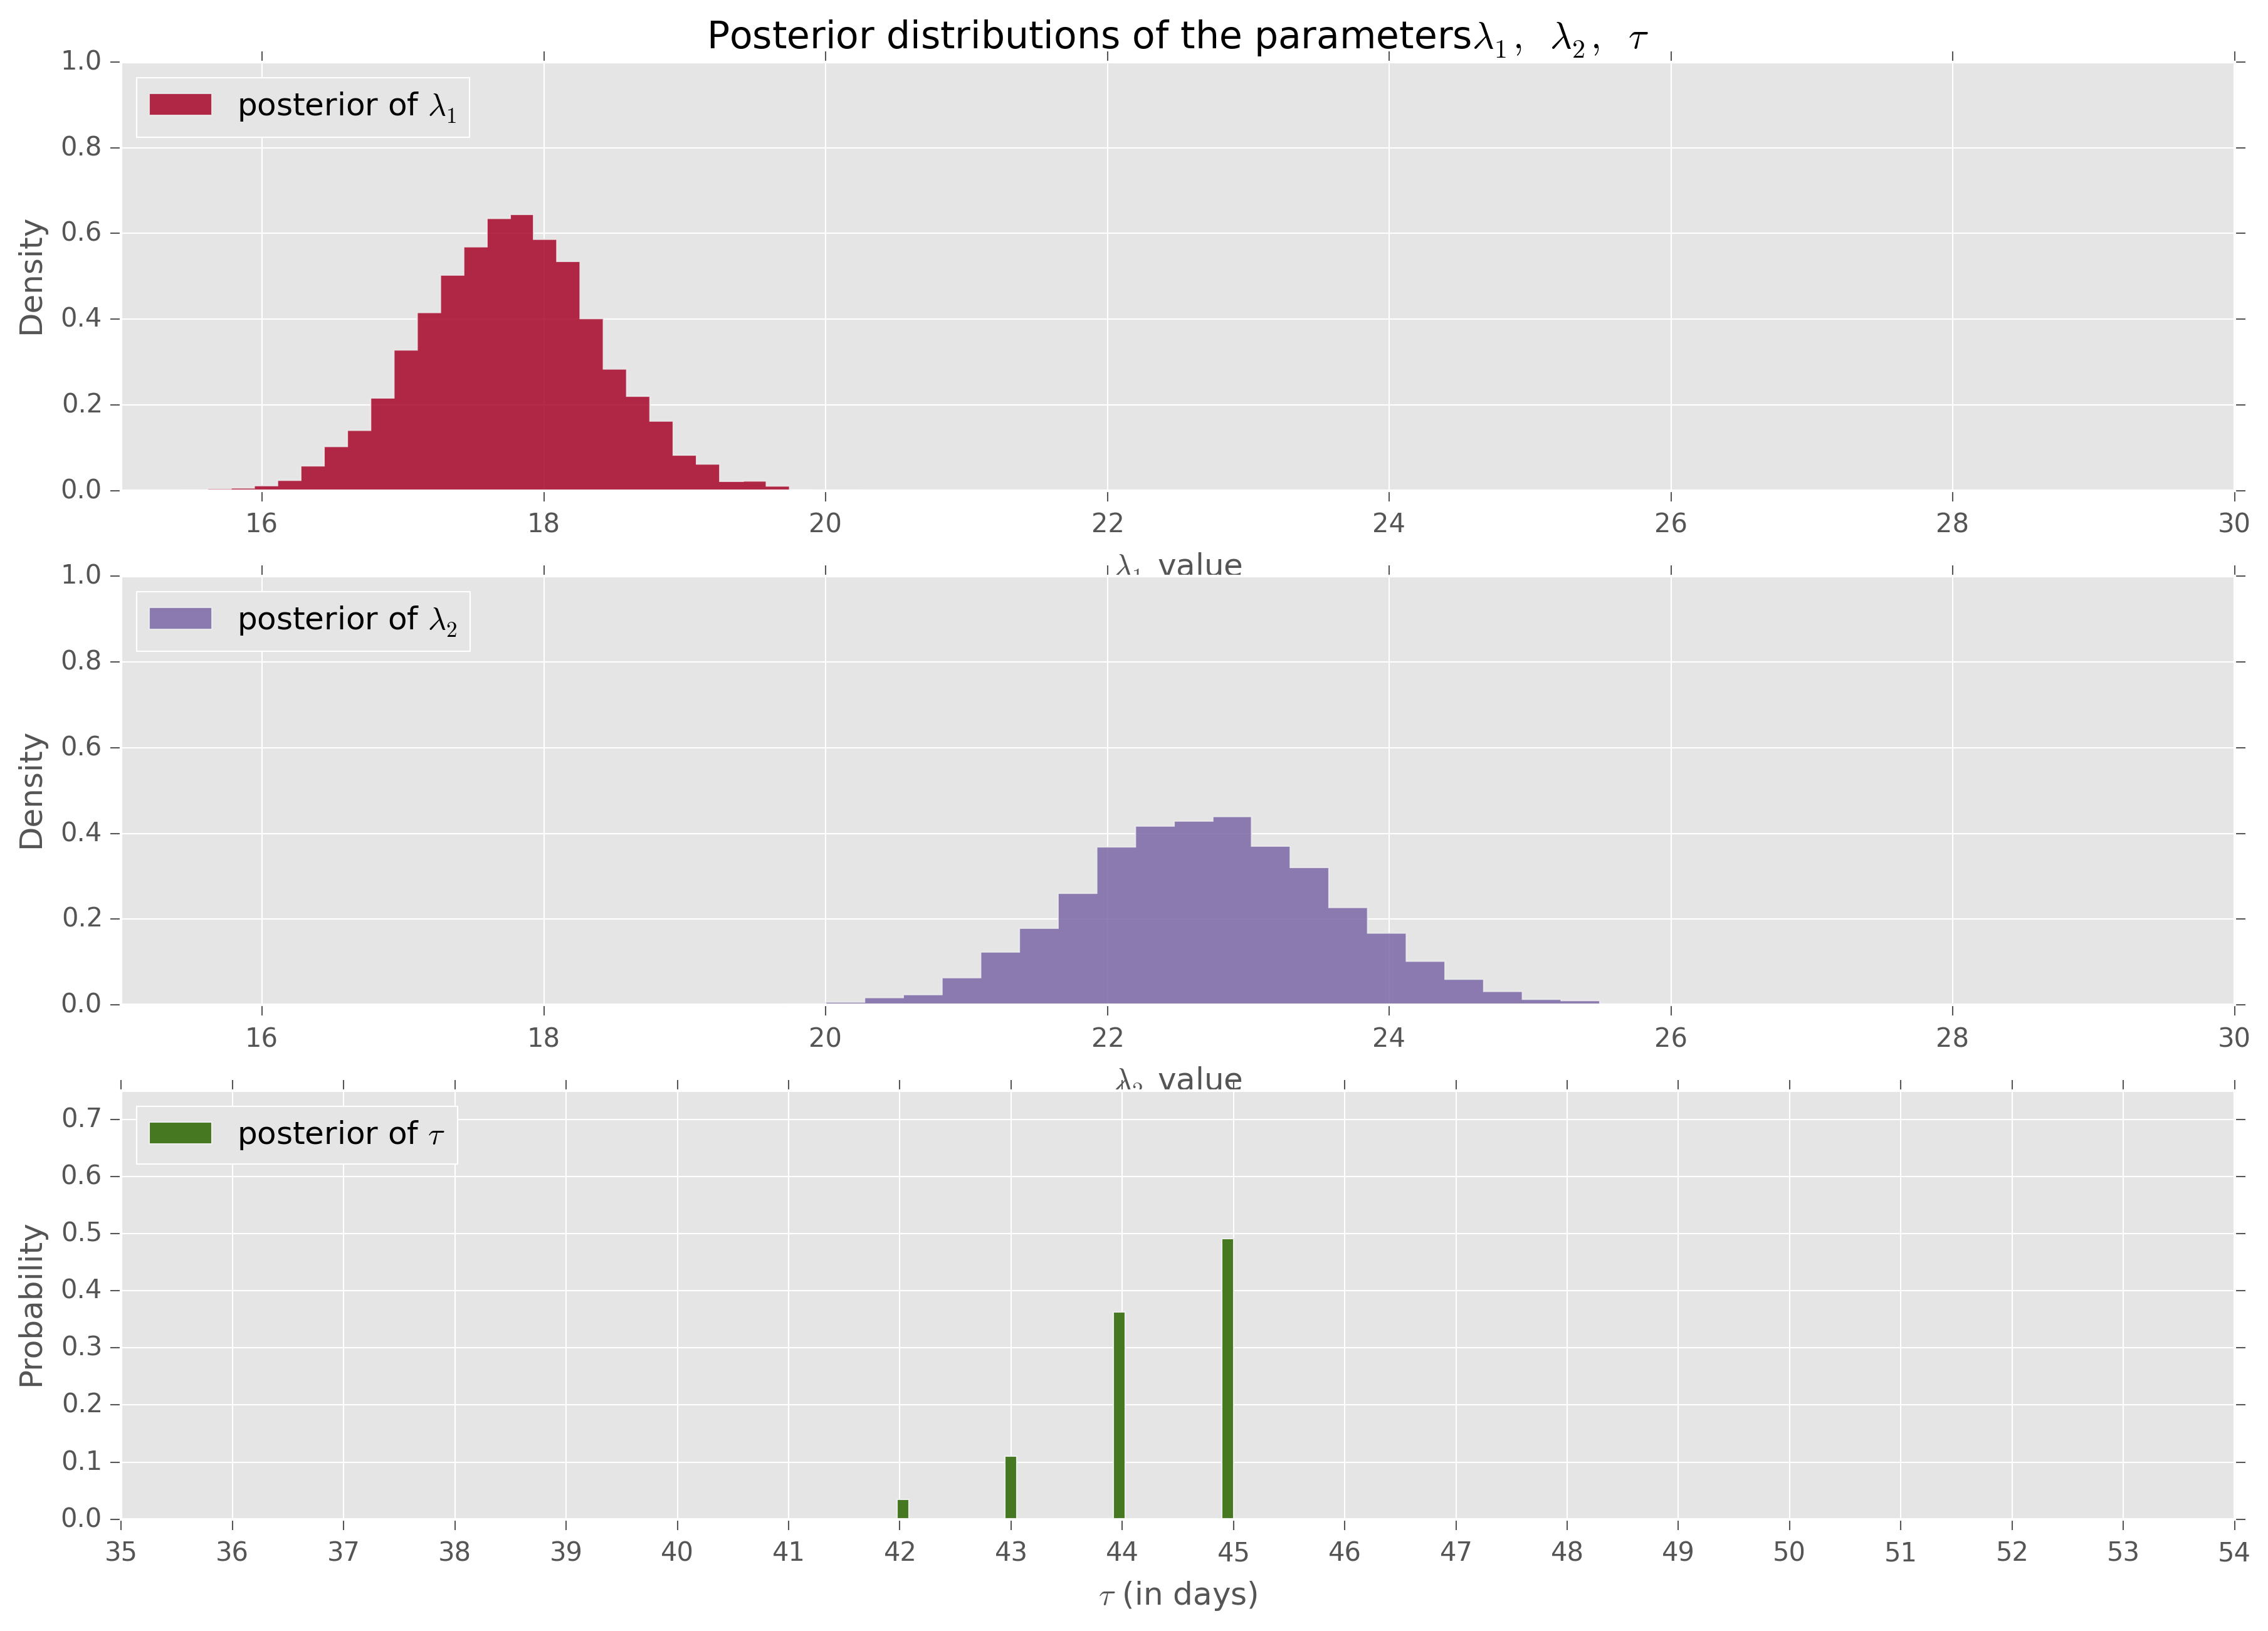

In [23]:
lambda_1_samples = mcmc.trace('lambda_1')[:]
lambda_2_samples = mcmc.trace('lambda_2')[:]
tau_samples = mcmc.trace('tau')[:]

figsize(14.5,10)
ax = plt.subplot(311)
ax.set_autoscaley_on(False)

plt.hist(lambda_1_samples, histtype='stepfilled',bins=30, alpha=0.85,
       label="posterior of $\lambda_1$", color="#A60628", normed=True)
plt.legend(loc="upper left")
plt.title(r"""Posterior distributions of the parameters\
$\lambda_1, \;\lambda_2, \;\tau$""")
plt.xlim([15, 30])
plt.xlabel("$\lambda_1$ value")
plt.ylabel("Density")

ax = plt.subplot(312)
ax.set_autoscaley_on(False)
plt.hist(lambda_2_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_2$", color="#7A68A6", normed=True)
plt.legend(loc="upper left")
plt.xlim([15, 30])
plt.xlabel("$\lambda_2$ value")
plt.ylabel("Density")

plt.subplot(313)
w = 1.0 / tau_samples.shape[0] * np.ones_like(tau_samples)
plt.hist(tau_samples, bins=n_count_data, alpha=1,
         label=r"posterior of $\tau$", color="#467821",
         weights=w, rwidth=2.)
plt.xticks(np.arange(n_count_data))
plt.legend(loc="upper left")
plt.ylim([0, .75])
plt.xlim([35, len(count_data)-20])
plt.xlabel(r"$\tau$ (in days)")
plt.ylabel("Probability");

### 1.4.4 What Good Are Samples from the Posterior Anyway?



[ 17.763768    17.763768    17.763768    17.763768    17.763768    17.763768
  17.763768    17.763768    17.763768    17.763768    17.763768    17.763768
  17.763768    17.763768    17.763768    17.763768    17.763768    17.763768
  17.763768    17.763768    17.763768    17.763768    17.763768    17.763768
  17.763768    17.763768    17.763768    17.763768    17.763768    17.763768
  17.763768    17.763768    17.763768    17.763768    17.763768    17.763768
  17.763768    17.76398612  17.76406321  17.76417227  17.76472981
  17.76734631  17.91799887  18.42523075  20.22522759  22.71179878
  22.71179878  22.71179878  22.71179878  22.71179878  22.71179878
  22.71179878  22.71179878  22.71179878  22.71179878  22.71179878
  22.71179878  22.71179878  22.71179878  22.71179878  22.71179878
  22.71179878  22.71179878  22.71179878  22.71179878  22.71179878
  22.71179878  22.71179878  22.71179878  22.71179878  22.71179878
  22.71179878  22.71179878  22.71179878]


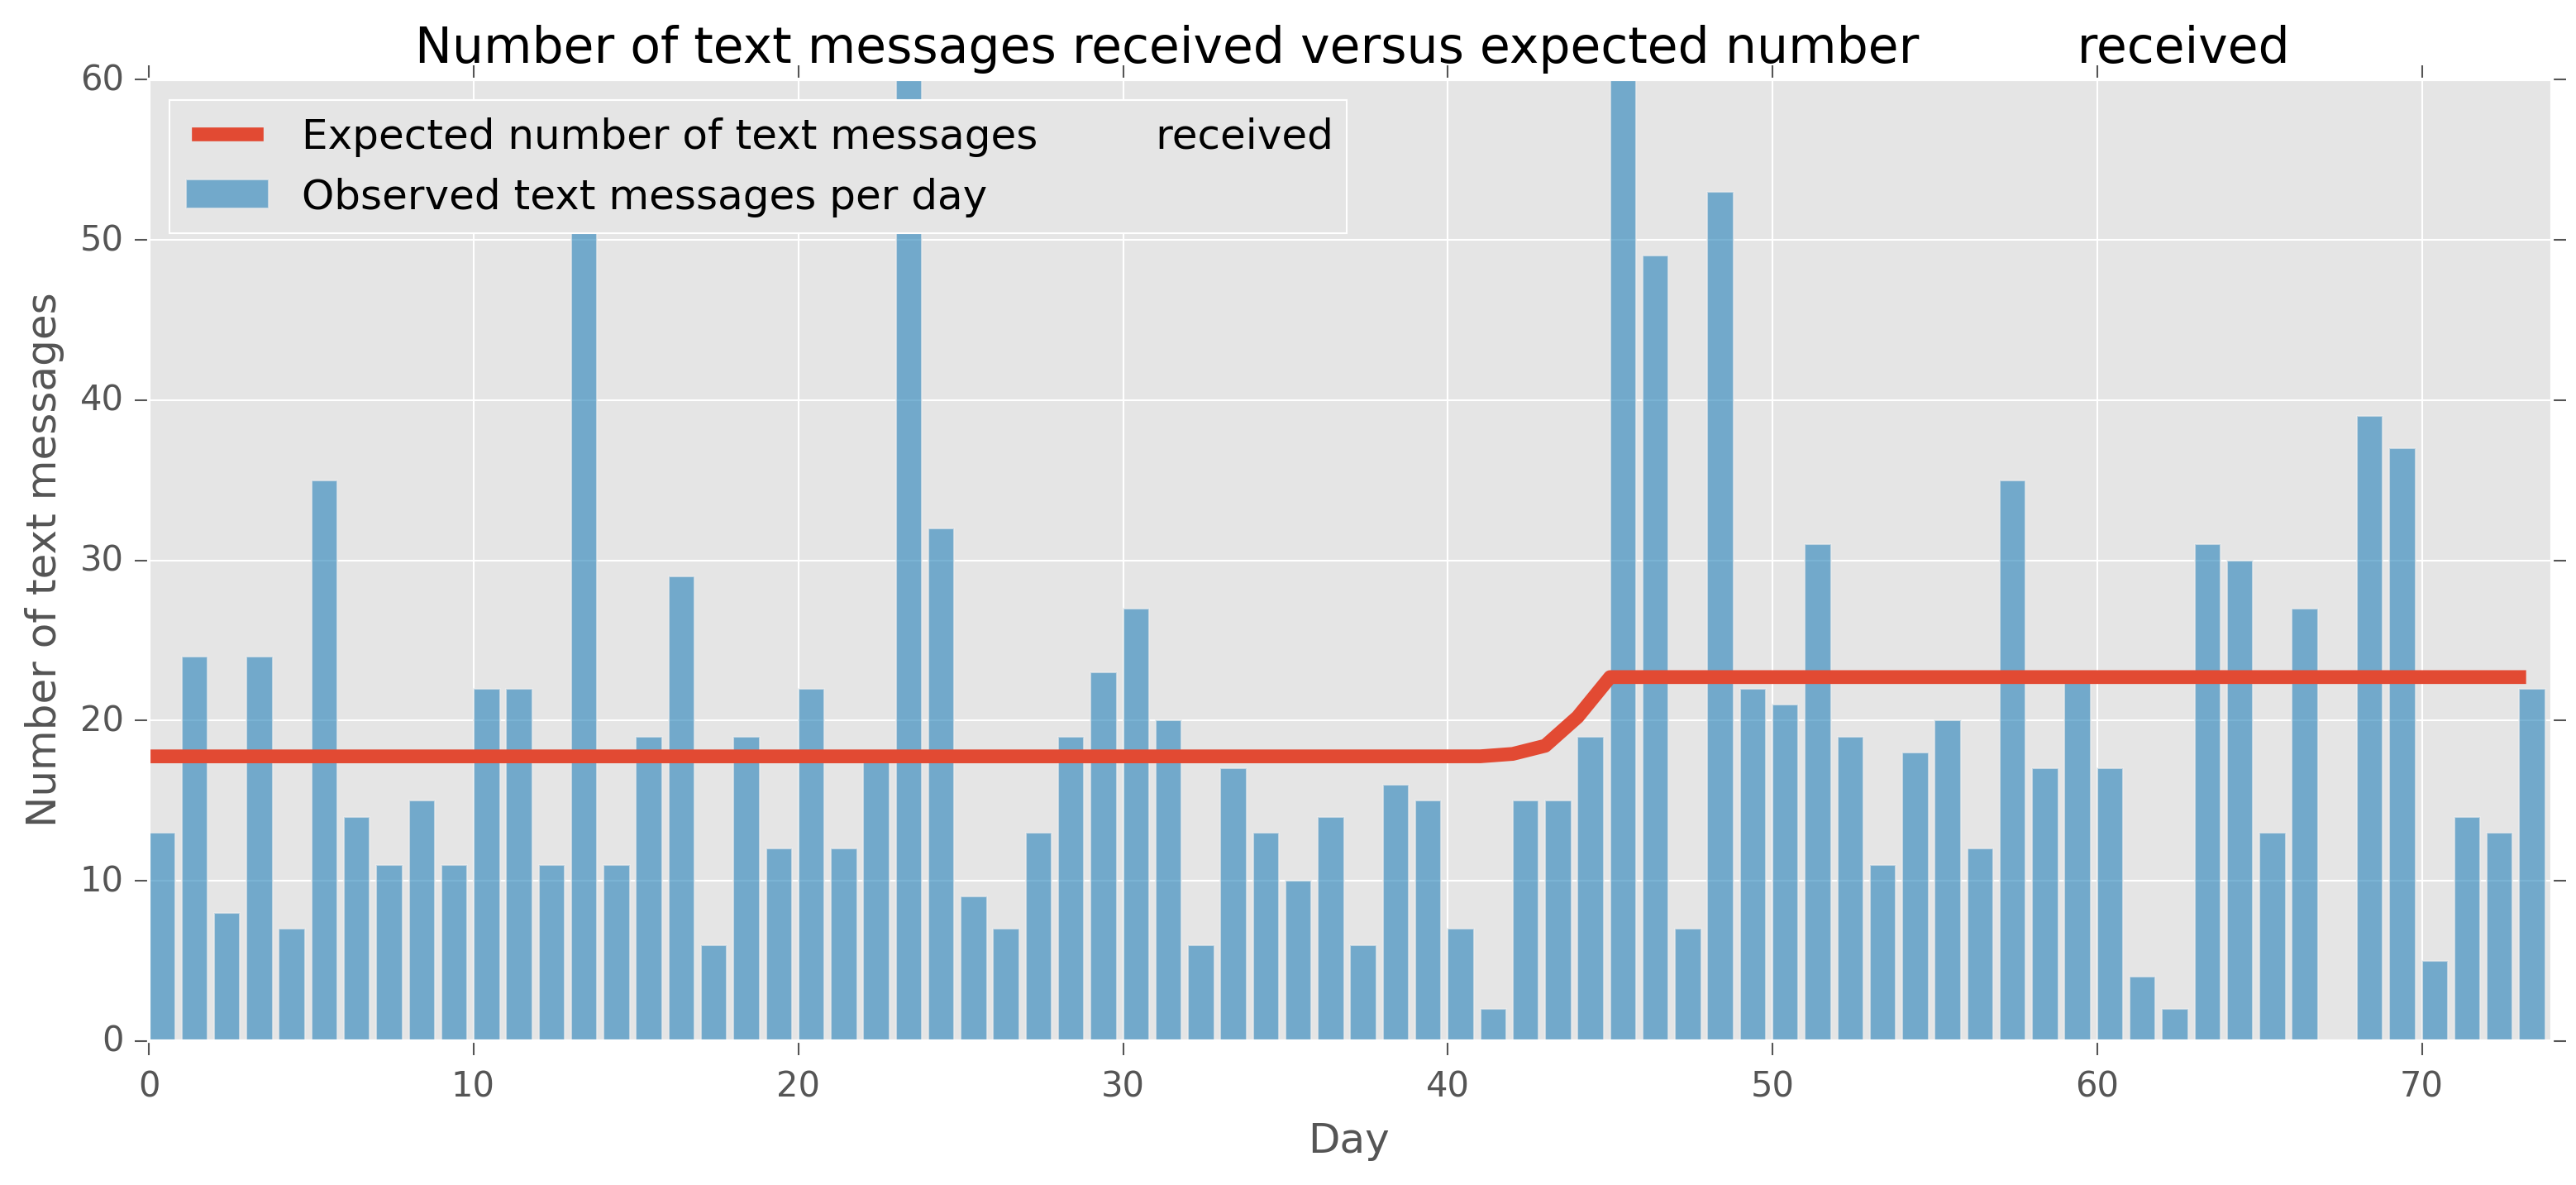

In [29]:
figsize(12.5, 5)
    # tau_samples, lambda_1_samples, lambda_2_samples contain 
    # N samples from the corresponding posterior distribution. 
N = tau_samples.shape[0]
expected_texts_per_day = np.zeros(n_count_data) # number of data points 
for day in range(0, n_count_data):
    # ix is a bool index of all tau samples corresponding to 
    # the switchpoint occurring prior to value of "day." 
    ix = day < tau_samples
    # Each posterior sample corresponds to a value for tau. 
    # For each day, that value of tau indicates whether we're 
    # "before" 
    # (in the lambda_1 "regime") or 
    # "after" (in the lambda_2 "regime") the switchpoint. 
    # By taking the posterior sample of lambda_1/2 accordingly, 
    # we can average 
    # over all samples to get an expected value for lambda on that day. 
    # As explained, the "message count" random variable is 
    # Poisson-distributed, 
    # and therefore lambda (the Poisson parameter) is the expected 
    # value of 
    # "message count." 
    expected_texts_per_day[day] = (lambda_1_samples[ix].sum()\
                                   + lambda_2_samples[~ix].sum()) / N
    
plt.plot(range(n_count_data), expected_texts_per_day, lw=4,
         color="#E24A33", label="Expected number of text messages\
         received")
plt.xlim(0, n_count_data)
plt.xlabel("Day")
plt.ylabel("Number of text messages")
plt.title("Number of text messages received versus expected number\
          received")
plt.ylim(0, 60)
plt.bar(np.arange(len(count_data)), count_data, color="#348ABD",
        alpha=0.65, label="Observed text messages per day")
plt.legend(loc="upper left")
print expected_texts_per_day